# ⭐ Tutorial: Financial Data Structures with RiskLabAI

This notebook serves as a tutorial for the `RiskLabAI` library, demonstrating how to convert standard tick data into advanced financial data structures, as described in 'Advances in Financial Machine learning' by Marcos López de Prado.

We will cover:
1.  **Standard Bars:** Time, Tick, Volume, and Dollar.
2.  **Analysis:** We'll show *why* alternative bars are superior by testing their returns for normality.
3.  **Information-Driven Bars:** Imbalance and Run bars.

## 0. Setup

First, we install and import all necessary libraries.

In [4]:
# --- 1. Installation ---
# !pip install RiskLabAI

# --- 2. Standard Library Imports ---
import os
import warnings

# --- 3. Third-Party Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# --- 4. RiskLabAI Library Imports ---
from RiskLabAI.data.structures.standard_bars import StandardBars
from RiskLabAI.data.structures.time_bars import TimeBars
from RiskLabAI.data.structures.imbalance_bars import ExpectedImbalanceBars
from RiskLabAI.data.structures.run_bars import ExpectedRunBars
from RiskLabAI.utils.constants import (
    CUMULATIVE_DOLLAR, 
    CUMULATIVE_VOLUME, 
    CUMULATIVE_TICKS
)
import RiskLabAI.utils.publication_plots as pub_plots

# --- 5. Notebook Configuration ---
warnings.filterwarnings("ignore")
pub_plots.setup_publication_style() # Apply global publication style

Matplotlib style updated for publication.


## 1. Load Data

We will use a publicly available tick dataset for the IVE ETF from 2020. The raw data is a list of tick data tuples: `(datetime, price, volume)`.

In [5]:
# Load the data from a public URL
data_url = "https://raw.githubusercontent.com/risk-labratory/data/main/IVE_2020.csv"
raw_df = pd.read_csv(data_url, parse_dates=['dates'])

# Filter for standard market hours (9:00 - 16:00)
raw_df = raw_df[
    (raw_df['dates'].dt.hour >= 9) & (raw_df['dates'].dt.hour < 16)
]

# The bar generation classes expect an iterable of tick data.
# We'll create a list of tuples: (datetime, price, volume)
# Note: We must sort by date first!
raw_df = raw_df.sort_values(by='dates').drop_duplicates()
tick_data_iterable = [
    (row.dates, row.price, row.size) 
    for row in raw_df.itertuples(index=False)
]

print(f"Loaded {len(tick_data_iterable)} ticks.")

# Preview the first 5 ticks
print(tick_data_iterable[:5])

Loaded 283370 ticks.
[(Timestamp('2020-01-02 09:30:00'), 130.68, 20625), (Timestamp('2020-01-02 09:30:01'), 130.5, 200), (Timestamp('2020-01-02 09:30:04'), 130.53, 100), (Timestamp('2020-01-02 09:30:04'), 130.55, 100), (Timestamp('2020-01-02 09:30:04'), 130.53, 200)]


## 2. Standard Bars

Standard bars aggregate ticks by a fixed unit of time, ticks, volume, or dollars.

### 2.1. Helper Function

We'll create a helper function to convert the list-of-lists output from our library into a clean, labeled `pandas.DataFrame`.

In [6]:
def bars_to_dataframe(bars_list: list) -> pd.DataFrame:
    """Converts the list output from bar constructors to a DataFrame."""
    
    # These are the column names our library generates
    # (from the `_construct_next_bar` method in `abstract_bars.py`)
    COL_NAMES = [
        'Date Time', 'Tick Index', 'Open', 'High', 'Low', 'Close',
        'Cumulative Volume', 'Cumulative Buy Volume', 'Cumulative Sell Volume',
        'Cumulative Ticks', 'Cumulative Dollar', 'Threshold'
    ]
    
    df = pd.DataFrame(bars_list, columns=COL_NAMES)
    df = df.set_index('Date Time')
    return df

### 2.2. Time Bars

Time bars are the most common, sampling at fixed time intervals (e.g., 15 minutes).

In [7]:
# 1. Instantiate the TimeBars class
# We will sample every 15 minutes
time_bar_generator = TimeBars(resolution_type='MIN', resolution_units=15)

# 2. Construct the bars
time_bars_list = time_bar_generator.construct_bars_from_data(tick_data_iterable)

# 3. Convert to a DataFrame
time_bars = bars_to_dataframe(time_bars_list)

print(f"Generated {len(time_bars)} 15-minute time bars.")
time_bars.head()

Generated 6624 15-minute time bars.


,Tick Index,Open,High,Low,Close,Cumulative Volume,Cumulative Buy Volume,Cumulative Sell Volume,Cumulative Ticks,Cumulative Dollar,Threshold
Date Time,,,,,,,,,,,
2020-01-02 09:45:00,192,130.68,130.78,130.4500,130.5400,143325,47675,95650,192,1.871823e+07,1577958300
2020-01-02 10:00:00,262,130.52,130.62,130.3700,130.4299,20723,10202,10521,70,2.703981e+06,1577959200
2020-01-02 10:15:00,305,130.40,130.40,130.2400,130.2400,14891,4149,10742,43,1.940535e+06,1577960100
2020-01-02 10:30:00,394,130.14,130.16,130.0218,130.0564,60336,33268,27068,89,7.849624e+06,1577961000
2020-01-02 10:45:00,475,130.08,130.08,129.9878,130.0600,21316,12784,8532,81,2.772359e+06,1577961900


### 2.3. Tick, Volume, and Dollar Bars

These bars are all generated by the `StandardBars` class. We just need to change the `bar_type` and `threshold`.

To set a reasonable threshold, we'll first calculate the daily averages and sample ~20 bars per day.

In [8]:
# Get number of trading days
num_days = len(raw_df['dates'].dt.date.unique())

# Calculate daily averages
daily_ticks = len(raw_df) / num_days
daily_volume = raw_df['size'].sum() / num_days
daily_dollar = (raw_df['price'] * raw_df['size']).sum() / num_days

# Set thresholds to get ~20 bars per day
bars_per_day = 20
tick_threshold = daily_ticks / bars_per_day
volume_threshold = daily_volume / bars_per_day
dollar_threshold = daily_dollar / bars_per_day

print(f"Tick Threshold: {tick_threshold:,.0f}")
print(f"Volume Threshold: {volume_threshold:,.0f}")
print(f"Dollar Threshold: {dollar_threshold:,.0f}")

# --- Generate Tick Bars ---
tick_bar_generator = StandardBars(
    bar_type=CUMULATIVE_TICKS, 
    threshold=tick_threshold
)
tick_bars_list = tick_bar_generator.construct_bars_from_data(tick_data_iterable)
tick_bars = bars_to_dataframe(tick_bars_list)

# --- Generate Volume Bars ---
volume_bar_generator = StandardBars(
    bar_type=CUMULATIVE_VOLUME, 
    threshold=volume_threshold
)
volume_bars_list = volume_bar_generator.construct_bars_from_data(tick_data_iterable)
volume_bars = bars_to_dataframe(volume_bars_list)

# --- Generate Dollar Bars ---
dollar_bar_generator = StandardBars(
    bar_type=CUMULATIVE_DOLLAR, 
    threshold=dollar_threshold
)
dollar_bars_list = dollar_bar_generator.construct_bars_from_data(tick_data_iterable)
dollar_bars = bars_to_dataframe(dollar_bars_list)

print(f"\nGenerated {len(tick_bars)} Tick Bars")
print(f"Generated {len(volume_bars)} Volume Bars")
print(f"Generated {len(dollar_bars)} Dollar Bars")

Tick Threshold: 56
Volume Threshold: 24,686
Dollar Threshold: 2,737,634

Generated 4971 Tick Bars
Generated 4184 Volume Bars
Generated 4162 Dollar Bars


## 3. Analysis: Standard Bars

Now, we'll replicate the analyses to show *why* Dollar Bars are a superior data structure.

### 3.1. Analysis 1: Bar Count Stability

This plot shows the number of bars generated per week. Time bars are constant, while the others adapt to market activity.

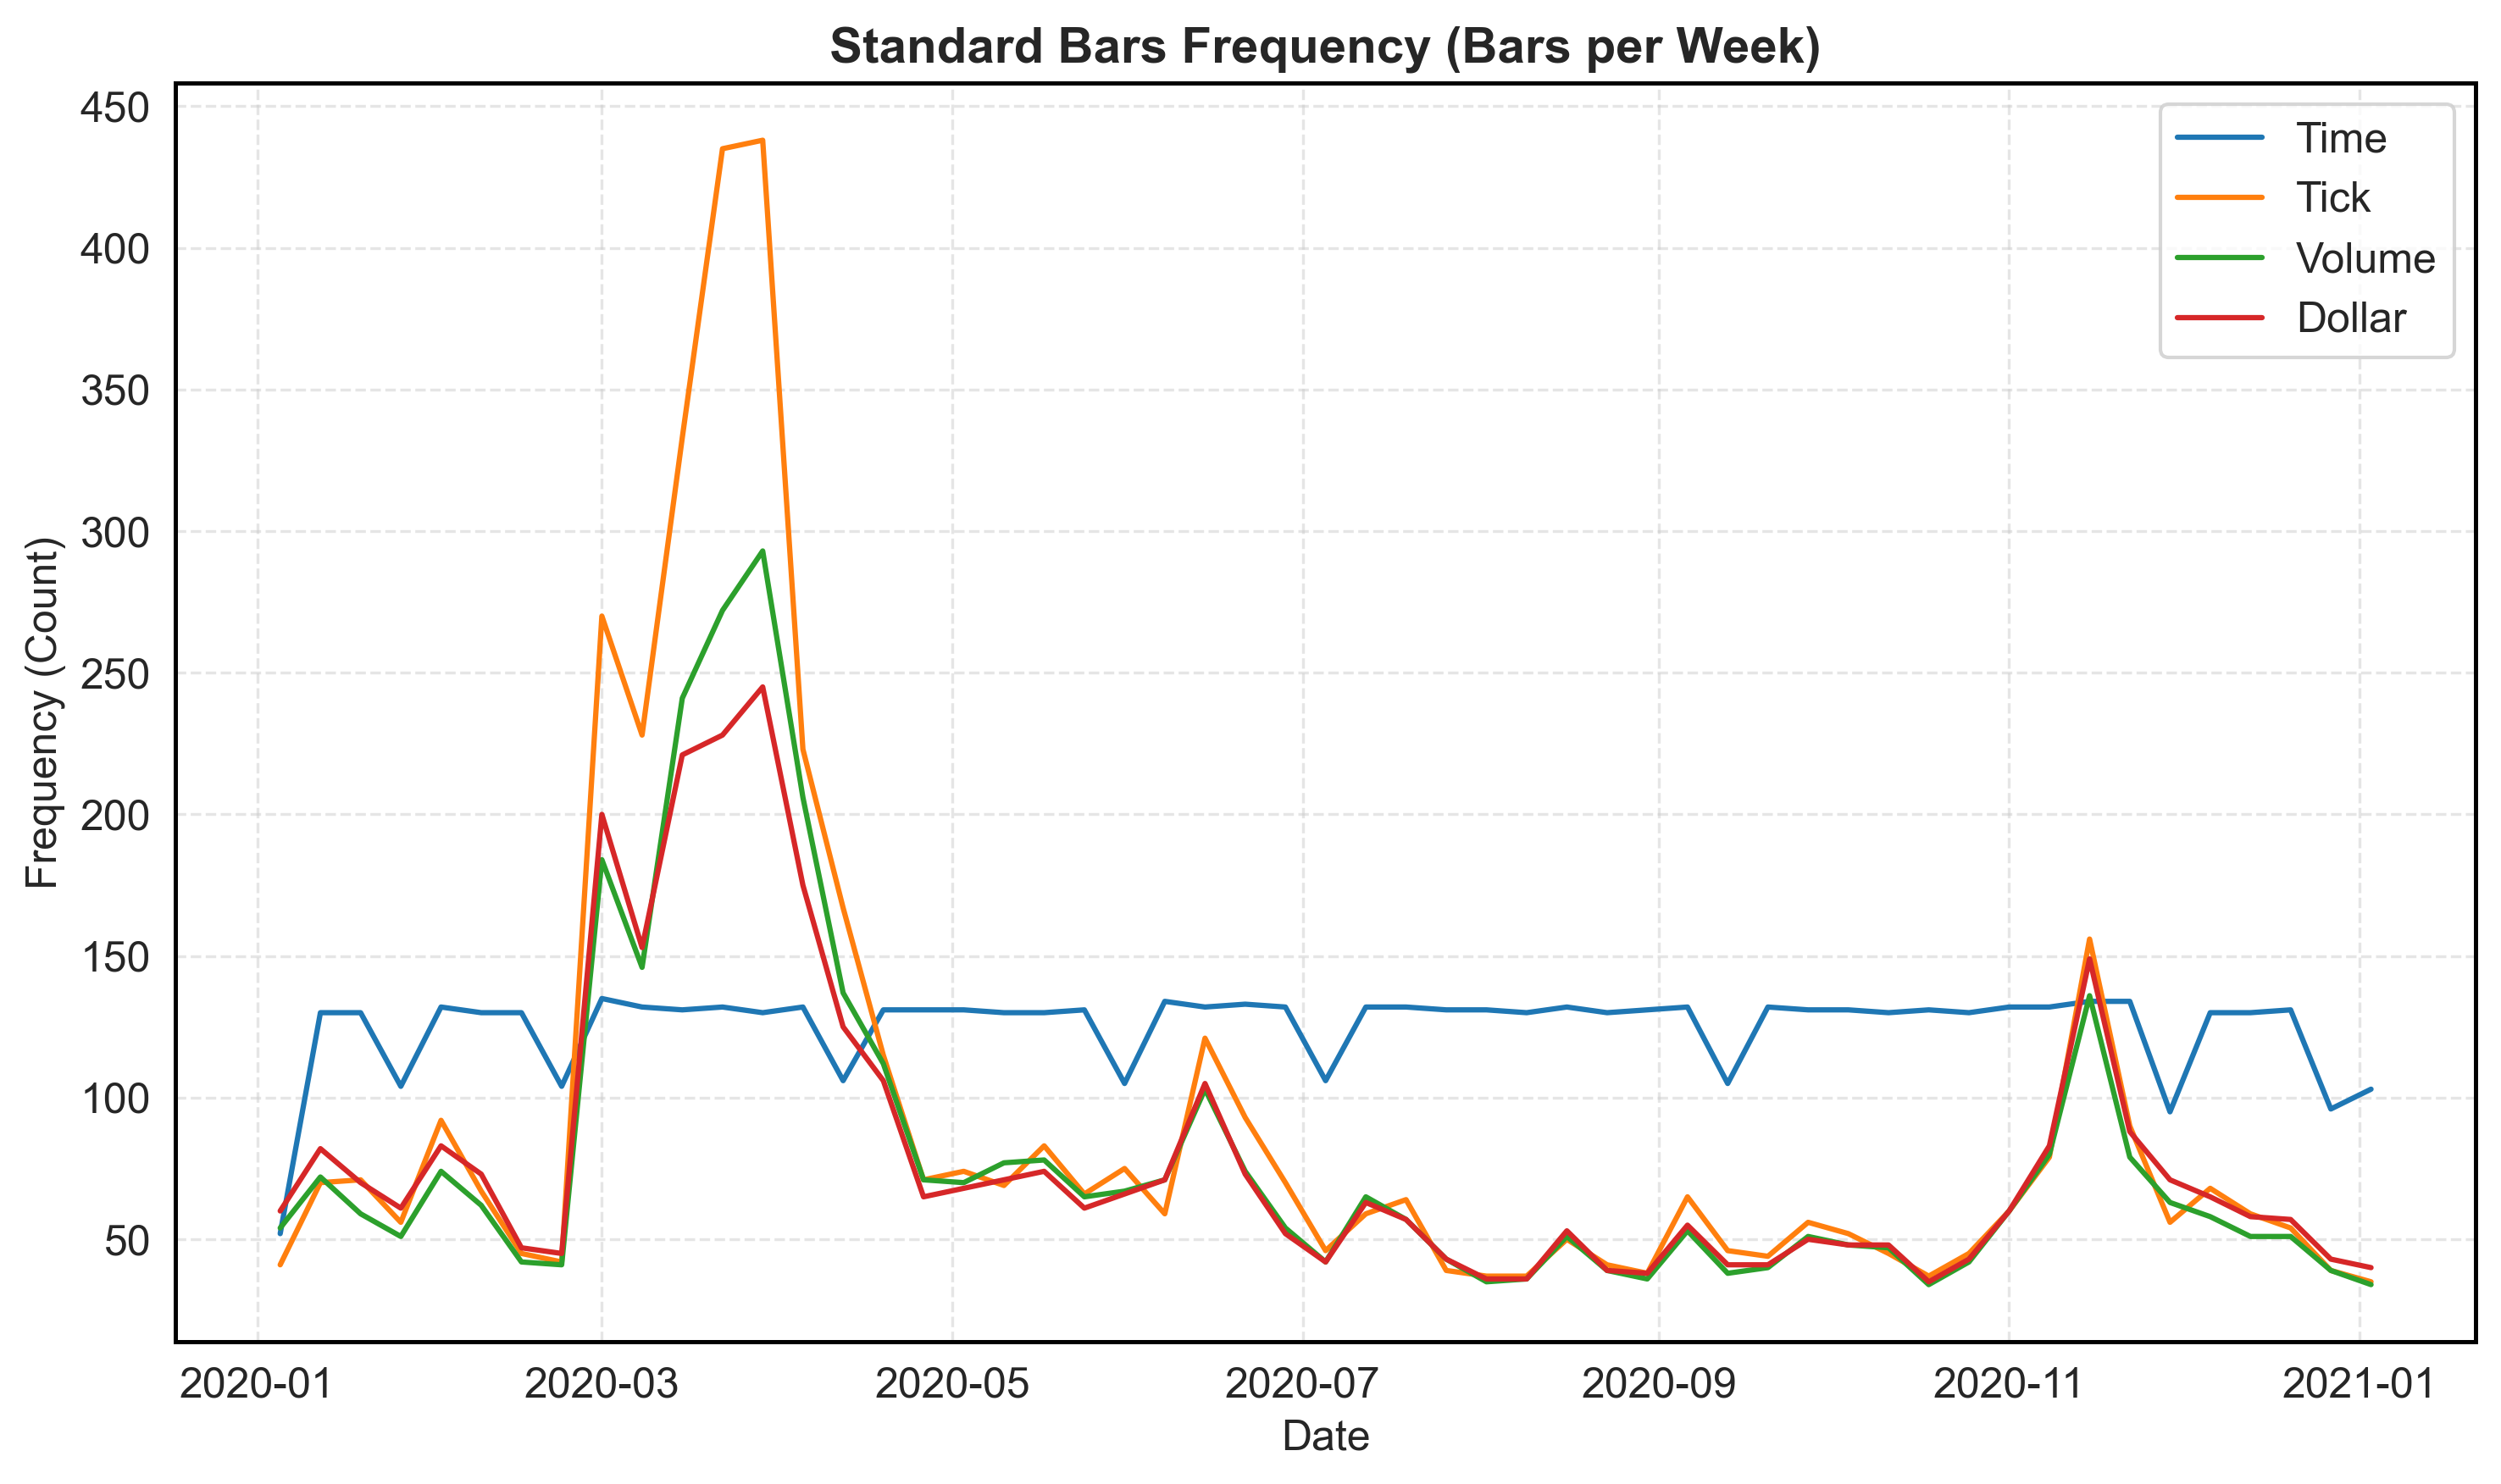

In [9]:
# Resample each bar type to get the count per week
count_df = pd.DataFrame({
    'Time': time_bars['Close'].resample('1W').count(),
    'Tick': tick_bars['Close'].resample('1W').count(),
    'Volume': volume_bars['Close'].resample('1W').count(),
    'Dollar': dollar_bars['Close'].resample('1W').count(),
}).dropna()


# Plot with Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(count_df.index, count_df['Time'], label='Time')
ax.plot(count_df.index, count_df['Tick'], label='Tick')
ax.plot(count_df.index, count_df['Volume'], label='Volume')
ax.plot(count_df.index, count_df['Dollar'], label='Dollar')

ax.legend()
pub_plots.apply_plot_style(
    ax,
    title='Standard Bars Frequency (Bars per Week)',
    xlabel='Date',
    ylabel='Frequency (Count)'
)
plt.tight_layout() # Adjust plot to prevent label overlap
plt.show()

**Observation:** As expected, Time bars have a perfectly constant frequency. Tick, Volume, and Dollar bars show a huge spike in activity during the March 2020 COVID-19 crash. This shows they are adapting to market volatility.

### 3.2. Analysis 2: Normality of Returns

The primary goal of these bars is to create a return series that is closer to the 'Normal' distribution (IID) required by many financial models.

In [10]:
# Calculate log returns
returns_df = pd.DataFrame({
    'Time': np.log(time_bars['Close']).diff().dropna(),
    'Tick': np.log(tick_bars['Close']).diff().dropna(),
    'Volume': np.log(volume_bars['Close']).diff().dropna(),
    'Dollar': np.log(dollar_bars['Close']).diff().dropna(),
})

# Standardize (z-score) for a clean comparison
standardized_returns = {
    'Time': (returns_df['Time'] - returns_df['Time'].mean()) / returns_df['Time'].std(),
    'Tick': (returns_df['Tick'] - returns_df['Tick'].mean()) / returns_df['Tick'].std(),
    'Volume': (returns_df['Volume'] - returns_df['Volume'].mean()) / returns_df['Volume'].std(),
    'Dollar': (returns_df['Dollar'] - returns_df['Dollar'].mean()) / returns_df['Dollar'].std(),
}

# --- Plot the distributions using Seaborn/Matplotlib ---
fig, ax = plt.subplots(figsize=(10, 6))

sns.kdeplot(standardized_returns['Time'], label='Time Bars', ax=ax)
sns.kdeplot(standardized_returns['Tick'], label='Tick Bars', ax=ax)
sns.kdeplot(standardized_returns['Volume'], label='Volume Bars', ax=ax)
sns.kdeplot(standardized_returns['Dollar'], label='Dollar Bars', ax=ax)
sns.kdeplot(np.random.normal(size=1000000), label='Normal (Ref.)', linestyle='--', color='black', ax=ax)

ax.set_xlim(-5, 5)
ax.legend()
pub_plots.apply_plot_style(
    ax,
    title='Distribution of Standardized Log Returns',
    xlabel='Standardized Log Return (Z-Score)',
    ylabel='Density'
)
plt.show()

ValueError: cannot reindex on an axis with duplicate labels

In [ ]:
# --- Run the Jarque-Bera Test ---
# The null hypothesis is that the data is normally distributed.
# A high statistic (and low p-value) means we reject the null.
# We want to see a *lower* test statistic.

print("--- Jarque-Bera Test for Normality ---")
print(f"(Lower is better)")

jb_time = stats.jarque_bera(returns_df['Time'])
jb_tick = stats.jarque_bera(returns_df['Tick'])
jb_volume = stats.jarque_bera(returns_df['Volume'])
jb_dollar = stats.jarque_bera(returns_df['Dollar'])

print(f"Time Bars:   \t{jb_time[0]:>10.2f} (p={jb_time[1]:.0f})")
print(f"Tick Bars:   \t{jb_tick[0]:>10.2f} (p={jb_tick[1]:.0f})")
print(f"Volume Bars: \t{jb_volume[0]:>10.2f} (p={jb_volume[1]:.0f})")
print(f"Dollar Bars: \t{jb_dollar[0]:>10.2f} (p={jb_dollar[1]:.0f})")

**Observation:** The results are clear. The Time bars have a very high Jarque-Bera statistic, showing they are extremely non-normal (high kurtosis, or 'fat tails'). The **Dollar Bars** have the lowest statistic, and their distribution plot is visibly the closest to the normal reference. This confirms they are the most statistically 'well-behaved' data structure.

## 4. Information-Driven Bars

Information-Driven Bars are more advanced. They sample not when a *threshold* is met, but when a *disequilibrium* in trade flow is detected.

### 4.1. Imbalance Bars

In [ ]:
# 1. Instantiate the ExpectedImbalanceBars class
e_imb_bar_generator = ExpectedImbalanceBars(
    bar_type="dollar_imbalance",
    window_size_for_expected_n_ticks_estimation=500, # EWMA window for E[T]
    initial_estimate_of_expected_n_ticks_in_bar=2000,
    window_size_for_expected_imbalance_estimation=10000 # EWMA window for E[b]
)

# 2. Construct the bars
e_imb_bars_list = e_imb_bar_generator.construct_bars_from_data(tick_data_iterable)

# 3. Convert to a DataFrame
e_imb_bars = bars_to_dataframe(e_imb_bars_list)

print(f"Generated {len(e_imb_bars)} Expected Dollar Imbalance Bars.")
e_imb_bars.head()

### 4.2. Run Bars

In [ ]:
# 1. Instantiate the ExpectedRunBars class
e_run_bar_generator = ExpectedRunBars(
    bar_type="dollar_run",
    window_size_for_expected_n_ticks_estimation=500,
    initial_estimate_of_expected_n_ticks_in_bar=2000,
    window_size_for_expected_imbalance_estimation=10000
)

# 2. Construct the bars
e_run_bars_list = e_run_bar_generator.construct_bars_from_data(tick_data_iterable)

# 3. Convert to a DataFrame
e_run_bars = bars_to_dataframe(e_run_bars_list)

print(f"Generated {len(e_run_bars)} Expected Dollar Run Bars.")
e_run_bars.head()

## 5. Conclusion

This notebook demonstrated how to use the `RiskLabAI` library to:
1.  **Directly instantiate** bar generation classes like `TimeBars`, `StandardBars`, and `ExpectedImbalanceBars`.
2.  **Pass an iterable** of tick data to the `construct_bars_from_data` method.
3.  **Analyze the results**, confirming that Dollar Bars produce a return series with more 'normal' statistical properties than standard Time Bars.